<a href="https://colab.research.google.com/github/maffant20/Deep-Learning-Project/blob/main/DL_Project_Part_2_Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries Import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import datasets,layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os
#Preprocessing Libraries
import os.path
from pathlib import Path
import glob

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
Training_Path = '/content/drive/MyDrive/Training Set for Self Driving Car/Train-20221224T150606Z-001/Train'

In [ ]:
Testing_Path = '/content/drive/MyDrive/Test Set for Self Driving Car/Test-20221224T150605Z-001/Test'

In [ ]:
Training_Images = sorted(glob.glob(os.path.join(Training_Path,'images','*.png')))
Training_Masks = sorted(glob.glob(os.path.join(Training_Path,'masks','*.png')))
Testing_Images= sorted(glob.glob(os.path.join(Testing_Path,'images','*.png')))
Testing_Masks = sorted(glob.glob(os.path.join(Testing_Path,'masks','*.png')))

In [ ]:
Training_Images[0]
Testing_Images[0]

'/content/drive/MyDrive/Test Set for Self Driving Car/Test-20221224T150605Z-001/Test/images/0016E5_07959.png'

In [ ]:
# Training_Images = os.listdir(Training_Path+'/images')
# Training_Masks = os.listdir(Training_Path+'/masks')

In [ ]:
imgs = []
masks = []

for i in range(len(Training_Images)):
  Img = tf.io.read_file(os.path.join(Training_Path, "images", Training_Images[i]))
  Img = tf.image.decode_png(Img, channels = 3)
  Img = tf.image.convert_image_dtype(Img, tf.float32)
  Mask = tf.io.read_file(os.path.join(Training_Path, "masks", Training_Masks[i]))
  Mask = tf.image.decode_png(Mask, channels=3)
  Mask = tf.math.reduce_max(Mask, -1, keepdims= True)
  height, width = Img.shape[0], Img.shape[1]
  h = 96
  w = 128
  Img = tf.image.resize(Img, (h,w), method='nearest')
  Mask = tf.image.resize(Mask, (h,w), method='nearest')
  imgs.append(Img)
  masks.append(Mask)
Train_Images = tf.stack(imgs,axis=0)
Train_Masks = tf.stack(masks,axis=0)
imgs = []
masks = []


for i in range(len(Testing_Images)):
  Img = tf.io.read_file(os.path.join(Testing_Path, "images", Testing_Images[i]))
  Img = tf.image.decode_png(Img, channels = 3)
  Img = tf.image.convert_image_dtype(Img, tf.float32)
  Mask = tf.io.read_file(os.path.join(Testing_Path, "masks", Testing_Masks[i]))
  Mask = tf.image.decode_png(Mask, channels=3)
  Mask = tf.math.reduce_max(Mask, -1, keepdims= True)
  height, width = Img.shape[0], Img.shape[1]
  h = 96
  w = 128
  Img = tf.image.resize(Img, (h,w), method='nearest')
  Mask = tf.image.resize(Mask, (h,w), method='nearest')
  imgs.append(Img)
  masks.append(Mask)
Test_Images = tf.stack(imgs,axis=0)
Test_Masks = tf.stack(masks,axis=0)



In [ ]:
print(Train_Masks.shape)
print(Train_Images.shape)
print(Test_Masks.shape)
print(Test_Images.shape)

(367, 96, 128, 1)
(367, 96, 128, 3)
(101, 96, 128, 1)
(101, 96, 128, 3)


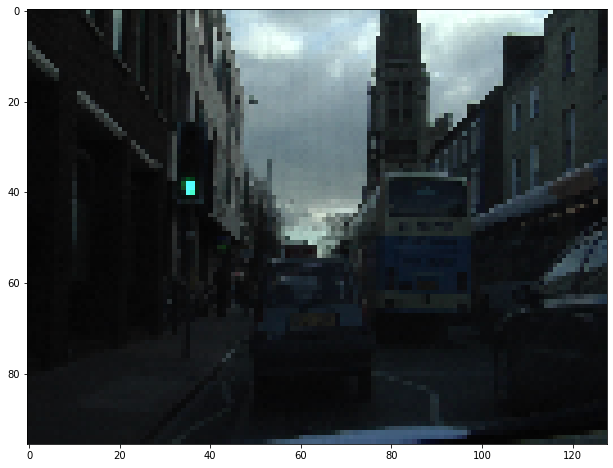

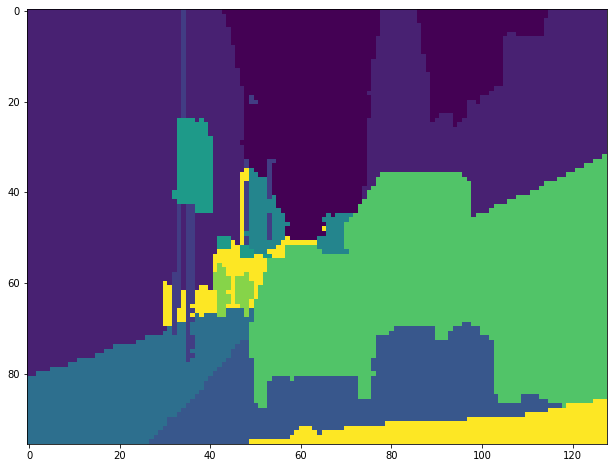

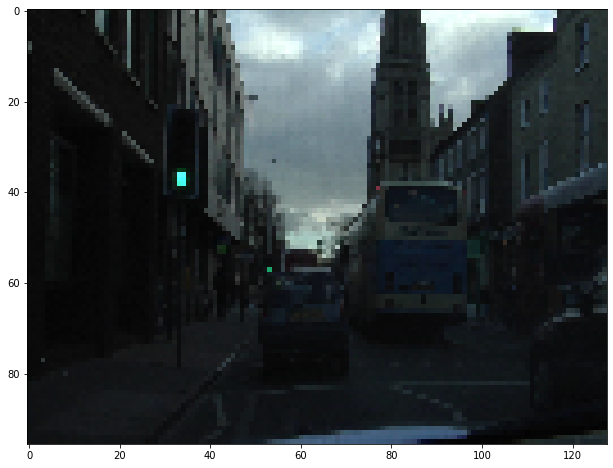

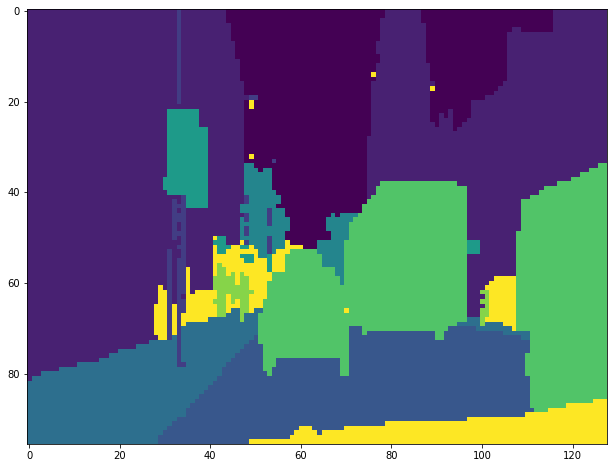

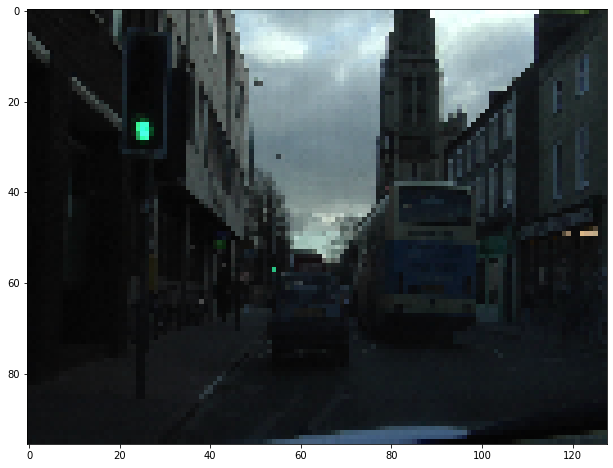

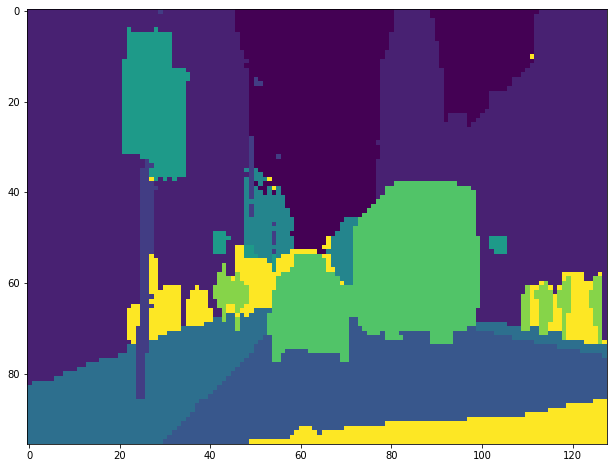

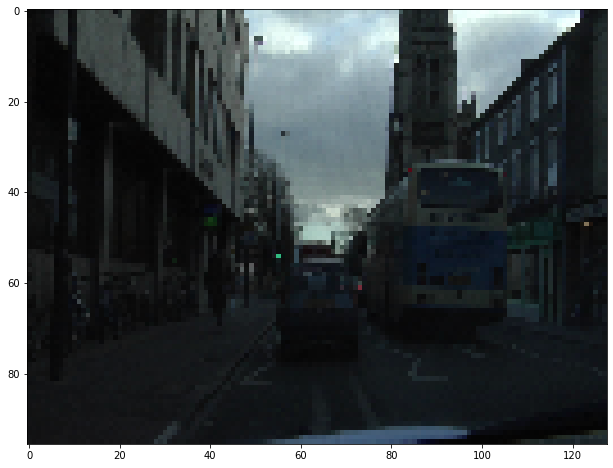

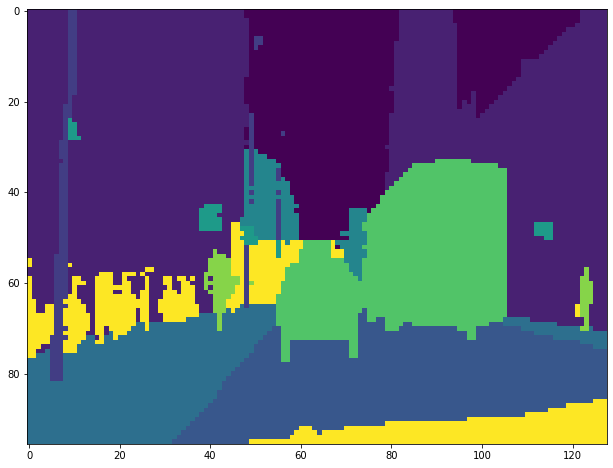

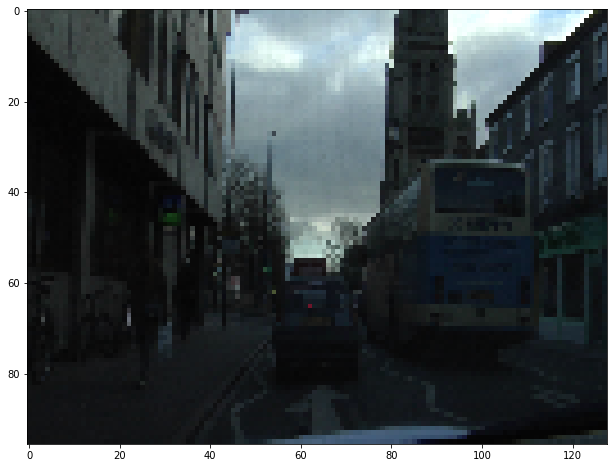

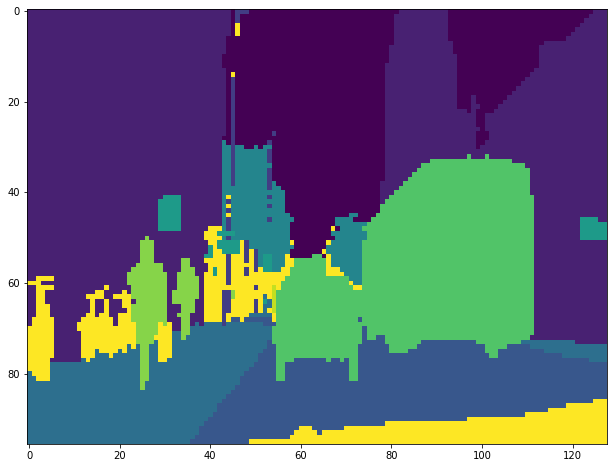

In [ ]:
for i in range(5):
  plt.figure(figsize = (25,8))

  plt.imshow(Train_Images[i])
  plt.show()
  plt.figure(figsize = (25,8))

  plt.imshow(tf.squeeze(Train_Masks[i]))
  plt.show()



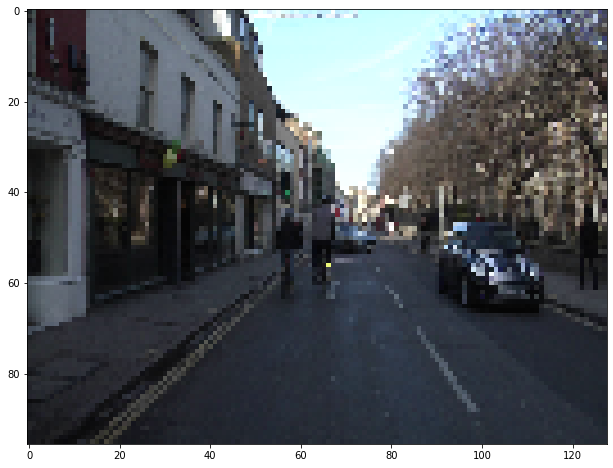

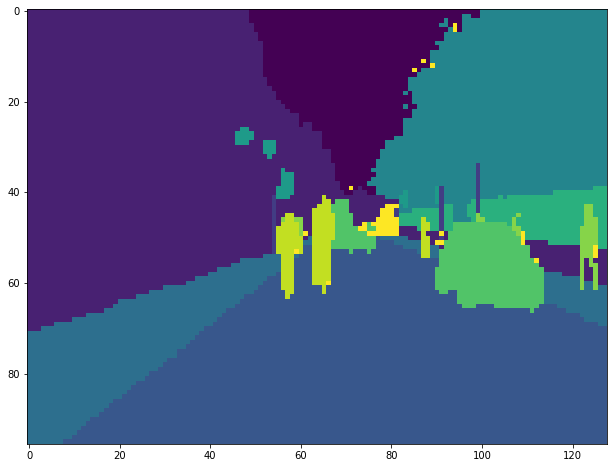

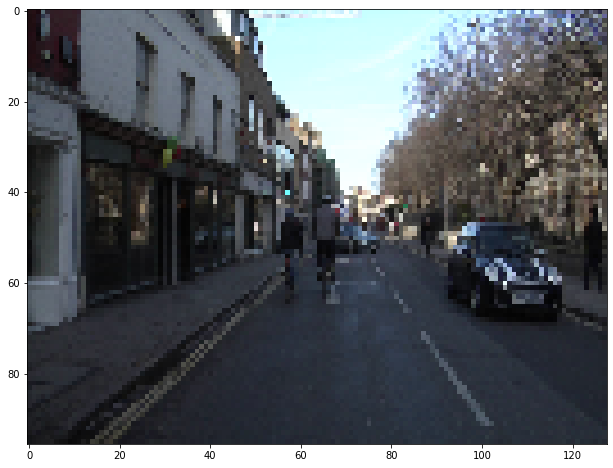

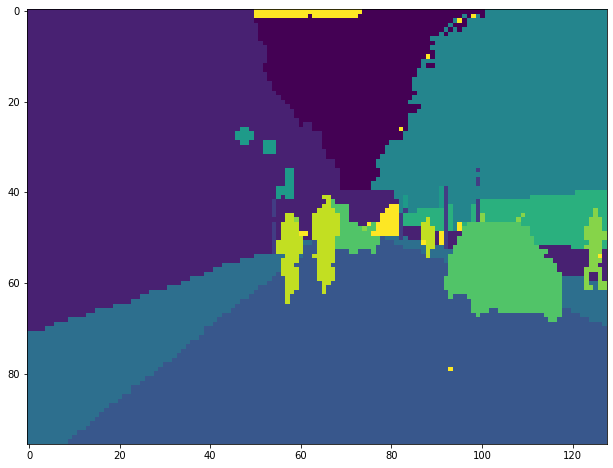

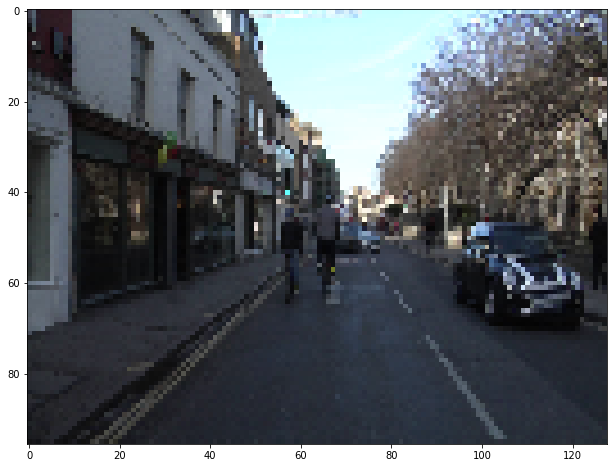

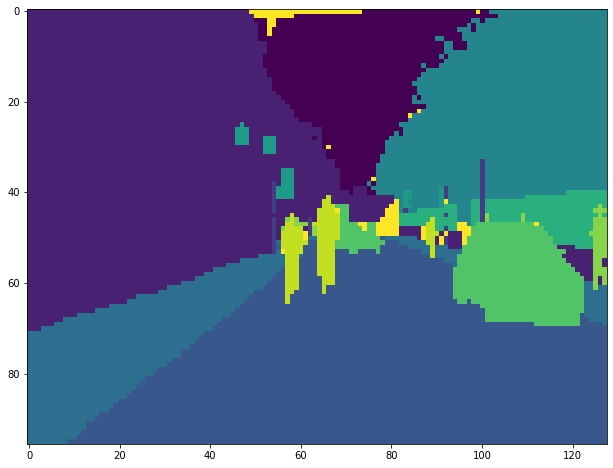

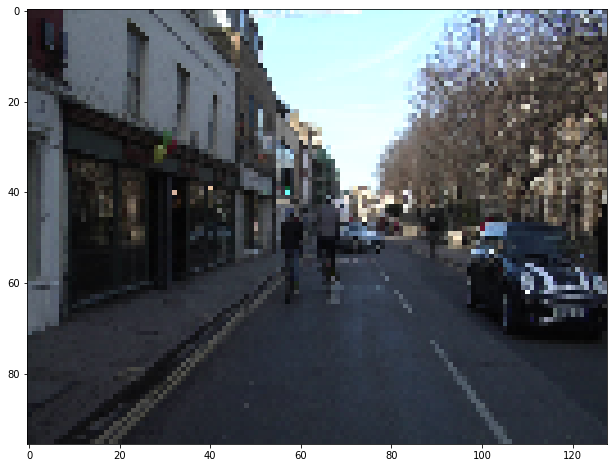

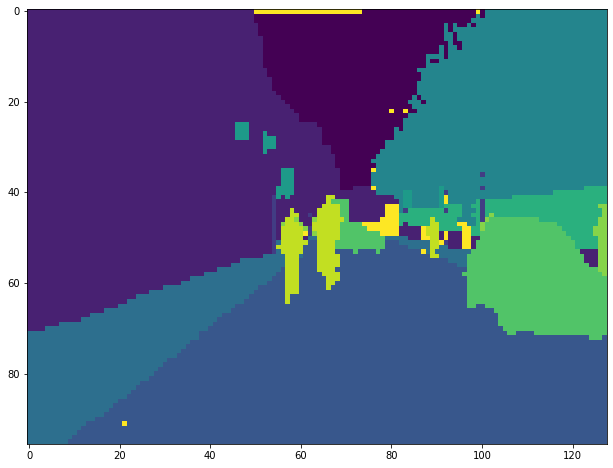

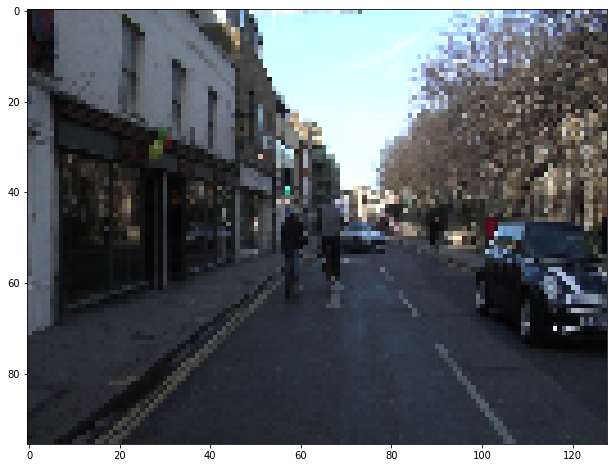

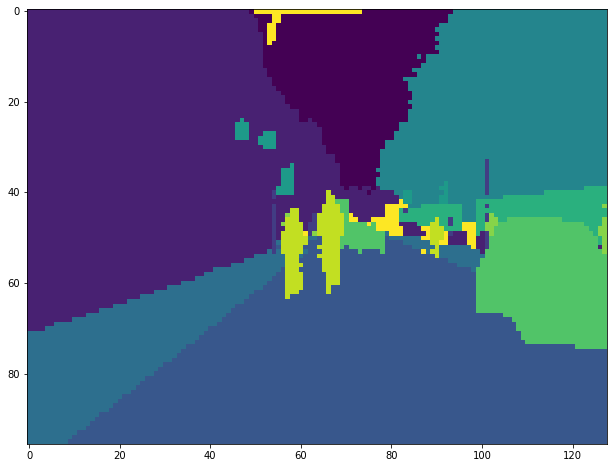

In [ ]:
for i in range(5):
  plt.figure(figsize = (25,8))

  plt.imshow(Test_Images[i])
  plt.show()
  plt.figure(figsize = (25,8))

  plt.imshow(tf.squeeze(Test_Masks[i]))
  plt.show()


In [ ]:
from tensorflow.python.keras import regularizers
from keras.layers import UpSampling2D, Dropout, BatchNormalization
def conv_block(inputs, num_filters, filter_size, dropout_p=0, max_pool = True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        num_filters -- Number of filters for the convolutional layers
        dropout_p -- Dropout probability
        max_pool -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        filter_size -- Denotes the size of each kernel of filter   
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    cnv = Conv2D(num_filters, (filter_size,filter_size), activation = 'relu', padding = 'same', kernel_initializer="he_normal" )(inputs)
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    cnv = BatchNormalization()(cnv)
    conv = Conv2D(num_filters, # Number of filters
                  (filter_size,filter_size),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(cnv)
    conv = BatchNormalization()(conv)
    if dropout_p > 0:
        dropout = Dropout(dropout_p)(conv)
    else:
        dropout = conv

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pool:
        maxpool = MaxPooling2D((2, 2), strides=2)(dropout)
    else:
        maxpool = dropout
    next_layer = maxpool  
    skip_connection = dropout
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, num_filters, filter_size):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        num_filters -- Number of filters for the convolutional layers
        filter_size -- Size of each kernel of filter over a conv2d transpose layer
    Returns: 
        conv -- Tensor output
    """
    
    upsampled_input = Conv2DTranspose(
                 num_filters,
                 (filter_size, filter_size),
                 strides=2,
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([upsampled_input, contractive_input], axis=3)
    conv2d = Conv2D(num_filters, 
                  (filter_size, filter_size), 
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(merge)
    conv2d = BatchNormalization()(conv2d)
    conv2d = Conv2D(num_filters, 
                  (filter_size, filter_size), 
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)
             
    return conv2d
    

    

In [ ]:
def unet(input_size, num_filters, num_classes):
  inputs = Input(input_size)
  conv_block_1 = conv_block(inputs =inputs, num_filters = num_filters*1, filter_size = 3, dropout_p=0)
  conv_block_2 = conv_block(inputs = conv_block_1[0],num_filters = num_filters*2, filter_size = 7, dropout_p=0)
  conv_block_3 = conv_block(inputs = conv_block_2[0],num_filters = num_filters*4, filter_size = 3, dropout_p=0)
  conv_block_4 = conv_block(inputs = conv_block_3[0],num_filters = num_filters*8, filter_size = 3, dropout_p=0)
  conv_block_5 = conv_block(inputs = conv_block_4[0],num_filters = num_filters*16, filter_size = 9, dropout_p=0.3)
  # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
  conv_block_6 = conv_block(inputs = conv_block_5[0],num_filters = num_filters*32, filter_size = 7, dropout_p=0.3, max_pool = False)
  deconv_block_7 = upsampling_block(conv_block_6[0], conv_block_5[1], num_filters * 16, filter_size = 3)
  deconv_block_8 = upsampling_block(deconv_block_7, conv_block_4[1], num_filters * 8, filter_size = 7)
  deconv_block_9 = upsampling_block(deconv_block_8, conv_block_3[1], num_filters * 4, filter_size = 3)
  deconv_block_10 = upsampling_block(deconv_block_9, conv_block_2[1], num_filters * 2, filter_size = 3)
  deconv_block_11 = upsampling_block(deconv_block_10, conv_block_1[1], num_filters * 1, filter_size = 9)
  conv2d = Conv2D(num_filters,(7, 7),activation="relu", padding="same")(deconv_block_11)
  # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
  outputs = Conv2D(num_classes, 1, padding="same")(conv2d)
    
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model
  
  
  



In [ ]:

unet= unet(input_size=Train_Images[0].shape, num_filters= 32, num_classes=12)


In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 128, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
Train_Images.shape

TensorShape([367, 96, 128, 3])

In [ ]:

unet.compile(
    tf.keras.optimizers.Adam(learning_rate =0.003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
path = '/content/drive/MyDrive/DL Project Part 2'
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="loss",
                                                      mode = 'min',
                                                      save_weights_only = True,
                                                      save_best_only = True,
                                                      verbose = 0,
                                                      filepath=path)


In [ ]:
EPOCHS = 5

model_history = unet.fit(
    Train_Images,
    Train_Masks,
    epochs=EPOCHS,
    batch_size = 8,
    callbacks = [Checkpoint_Model],
    verbose=True
)

Epoch 1/5
46/46 [==============================] - 433s 9s/step - loss: 1.2073 - accuracy: 0.6416
Epoch 2/5
46/46 [==============================] - 459s 10s/step - loss: 0.9395 - accuracy: 0.6918
Epoch 3/5
46/46 [==============================] - 459s 10s/step - loss: 0.8527 - accuracy: 0.7338
Epoch 4/5
46/46 [==============================] - 471s 10s/step - loss: 0.7770 - accuracy: 0.7624
Epoch 5/5
46/46 [==============================] - 451s 10s/step - loss: 0.7418 - accuracy: 0.7767


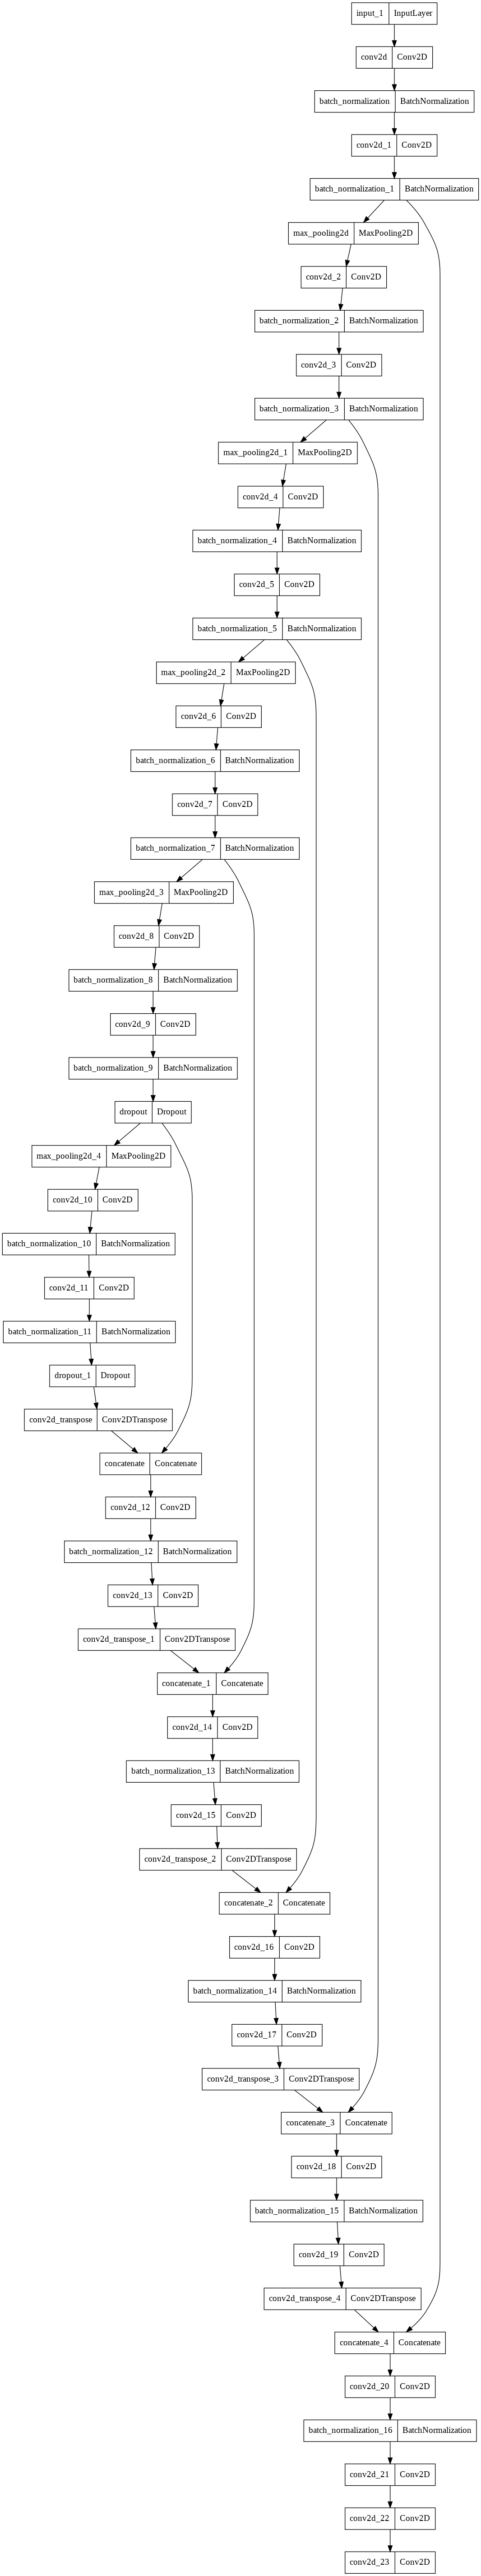

In [ ]:
tf.keras.utils.plot_model(unet)

Text(0, 0.5, 'Accuracy')

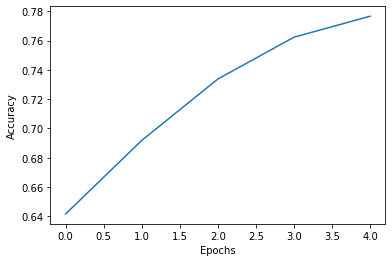

In [ ]:

plt.plot(model_history.history["accuracy"])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Loss')

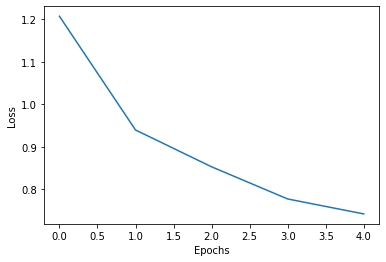

In [ ]:

plt.plot(model_history.history["loss"])

plt.xlabel('Epochs')
plt.ylabel('Loss')

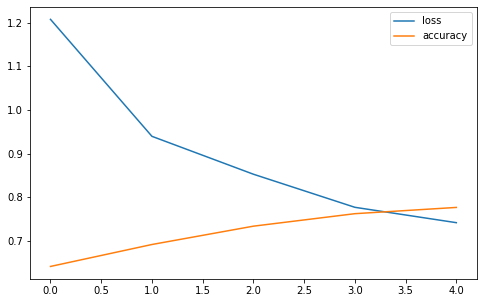

In [ ]:
import pandas as pd
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
def display(l_list):
  
  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(l_list)):
    plt.figure(figsize=(20, 20))
 
    plt.subplot(1, len(l_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(l_list[i]))
    plt.axis('off')
    
    plt.show()


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

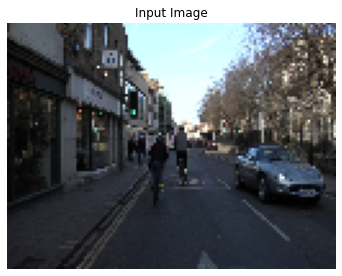

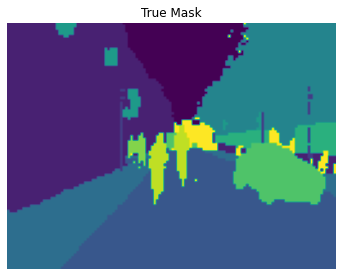

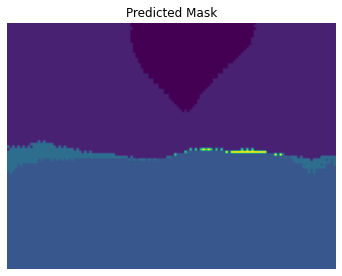

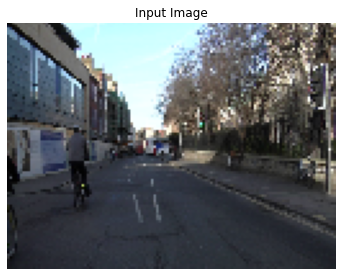

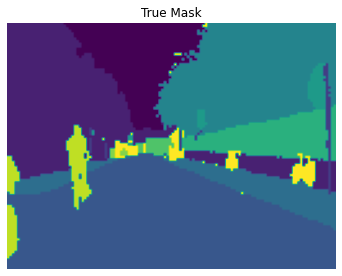

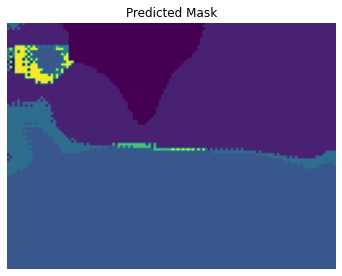

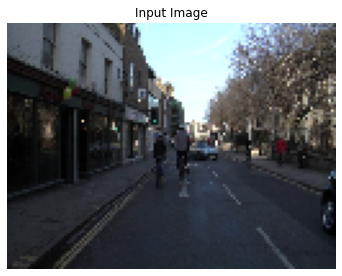

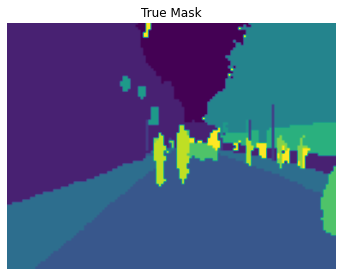

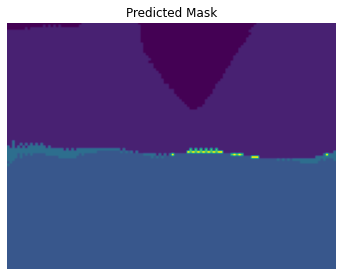

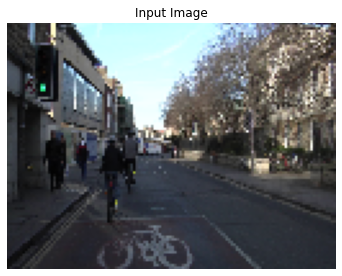

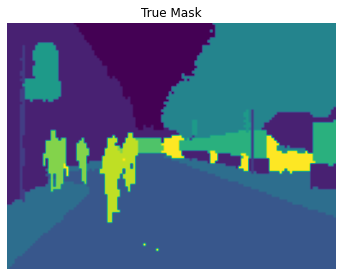

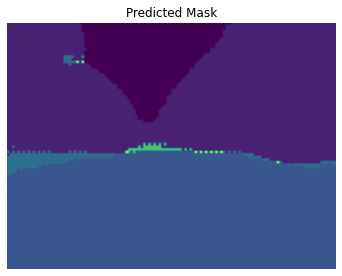

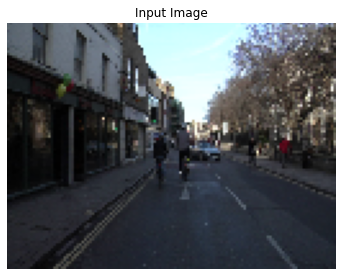

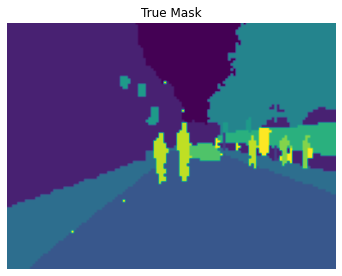

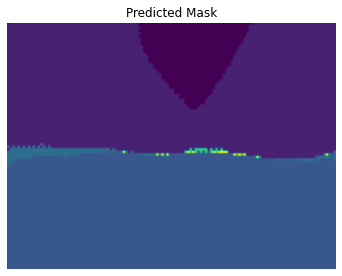

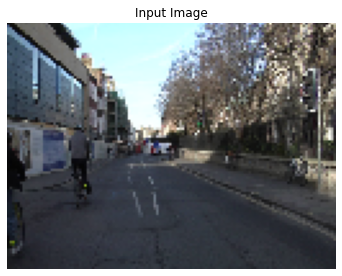

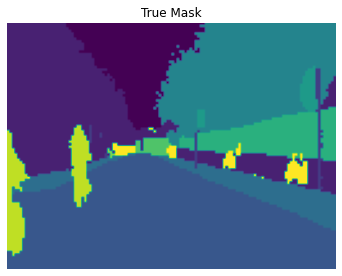

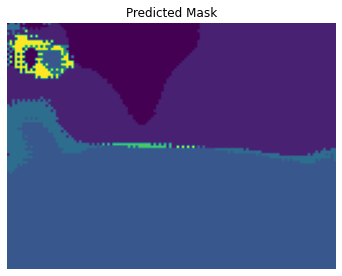

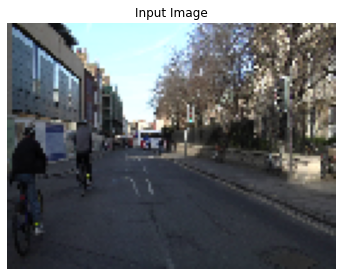

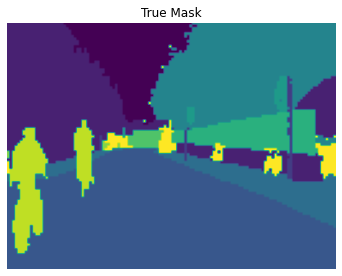

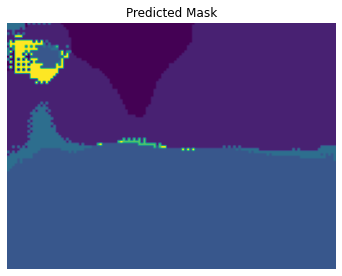

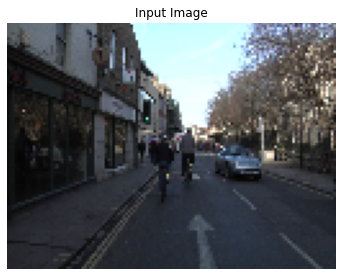

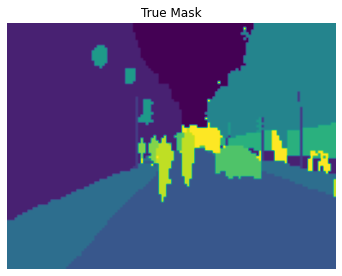

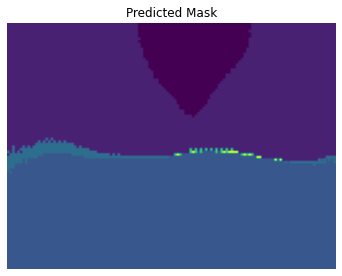

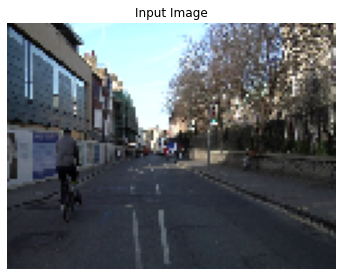

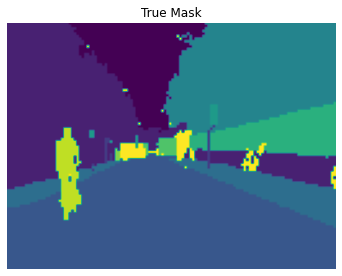

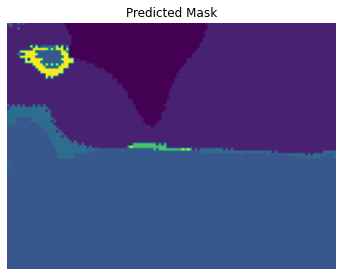

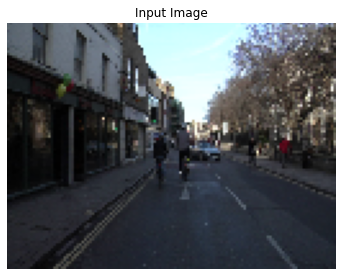

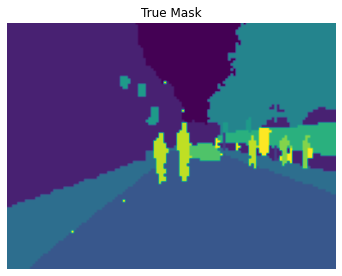

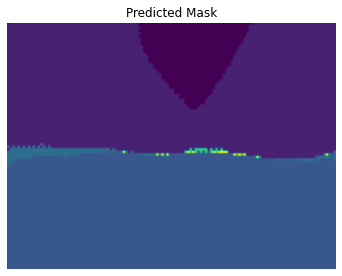

In [ ]:
for i in range(10):
    index = np.random.randint(Test_Images.shape[0])

    input_image = Test_Images[index]
    true_mask = Test_Masks[index]
    
    pred_mask = unet(tf.expand_dims(input_image, axis=0))
    pred_mask = create_mask(pred_mask)

    display([input_image, true_mask, pred_mask])

In [ ]:
unet.save('Unet-On-SDC.h5')
unet.save_weights('Unet_weights.h5')


In [ ]:


true_masks,predicted_masks = [], []
pred_mask = unet.predict(Train_Images)
pred_mask = tf.expand_dims(tf.argmax(pred_mask,axis=-1), axis = -1)
predicted_masks.extend(pred_mask)
predicted_masks = np.array(predicted_masks)



12/12 [==============================] - 95s 8s/step


In [ ]:
print(predicted_masks.shape)

(367, 96, 128, 1)


In [ ]:
print(Train_Masks.shape)

(367, 96, 128, 1)


In [ ]:
import pandas as pd
def evaluate(true_masks, predicted_masks, n_classes, smooth = 1e-6):

  class_wise_true_positives, class_wise_true_negatives = [],[]
  class_wise_false_positives, class_wise_false_negatives = [],[]
  class_wise_precisions, class_wise_recalls = [],[] 
  class_wise_specificities, class_wise_ious = [],[] 
  class_wise_tdrs, class_wise_f1_scores = [],[]
  classes = []
  for clas in range(n_classes):
    true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
    precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0
    number_of_masks = true_masks.shape[0]
        
    for mask_id in range(number_of_masks):
      true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
      true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
      false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
      false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
      true_positives += true_positive
      true_negatives += true_negative
      false_positives += false_positive
      false_negatives += false_negative
    recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
    precision = round(true_positives/(true_positives + false_positives + smooth), 2)
    specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
    tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
    iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
    f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
    class_wise_true_positives.append(true_positives)
    class_wise_true_negatives.append(true_negatives)
    class_wise_false_positives.append(false_positives)
    class_wise_false_negatives.append(false_negatives)
    class_wise_recalls.append(recall)
    class_wise_precisions.append(precision)
    class_wise_specificities.append(specificity)
    class_wise_ious.append(iou)
    class_wise_tdrs.append(tdr)
    class_wise_f1_scores.append(f1_score)
    classes.append("Class " + str(clas+1))
        
  total_true_positives = np.sum(class_wise_true_positives)
  total_true_negatives = np.sum(class_wise_true_negatives)
  total_false_positives = np.sum(class_wise_false_positives)
  total_false_negatives = np.sum(class_wise_false_negatives)
  mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
  mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
  mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
  mean_iou = round(np.average(np.array(class_wise_ious)), 2)
  mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
  mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
  class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

  overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
  evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
  
  metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"]
        
  return evaluations, metrics

   


In [ ]:
evaulations, metrics = evaluate(Train_Masks, predicted_masks, 12)


In [ ]:
Class_Wise = evaulations['Class-wise Evaluations']
print('Classes:',Class_Wise['Class'])
print('TP:',Class_Wise['True Positive Pixels'])
print('TN:',Class_Wise['True Negative Pixels'])
print('FP:',Class_Wise['False Positive Pixels'])
print('FN:',Class_Wise['False Negative Pixels'])
print('Precision:',Class_Wise['Precision'])
print('Recall:',Class_Wise['Recall'])
print('IOU:',Class_Wise['IoU'])
print('F_score:',Class_Wise['F1-Score'])







Classes: ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12']
TP: [627730, 901301, 0, 1425425, 1666, 4843, 0, 0, 7439, 0, 0, 411]
TN: [3692141, 2742005, 4465239, 2427326, 4213151, 4070181, 4457031, 4458894, 4234640, 4480834, 4496576, 4327757]
FP: [57537, 719091, 0, 655142, 94308, 988, 0, 0, 10477, 0, 0, 3338]
FN: [132288, 147299, 44457, 1803, 200571, 433684, 52665, 50802, 257140, 28862, 13120, 178190]
Precision: [0.92, 0.56, 0.0, 0.69, 0.02, 0.83, 0.0, 0.0, 0.42, 0.0, 0.0, 0.11]
Recall: [0.83, 0.86, 0.0, 1.0, 0.01, 0.01, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0]
IOU: [0.77, 0.51, 0.0, 0.68, 0.01, 0.01, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0]
F_score: [0.87, 0.68, 0.0, 0.82, 0.01, 0.02, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0]


Second Model For Ensemble Learning

In [ ]:


def unet2(input_size, num_filters, num_classes):
  inputs = Input(input_size)
  conv_block_1 = conv_block(inputs =inputs, num_filters = num_filters*1, filter_size = 3, dropout_p=0)
  conv_block_2 = conv_block(inputs = conv_block_1[0],num_filters = num_filters*2, filter_size = 3, dropout_p=0)
  conv_block_3 = conv_block(inputs = conv_block_2[0],num_filters = num_filters*4, filter_size = 3, dropout_p=0)
  conv_block_4 = conv_block(inputs = conv_block_3[0],num_filters = num_filters*8, filter_size = 3, dropout_p=0.3)
  conv_block_5 = conv_block(inputs = conv_block_4[0],num_filters = num_filters*32, filter_size = 3, dropout_p=0.3, max_pool = False)
  deconv_block_6 = upsampling_block(conv_block_5[0], conv_block_4[1], num_filters * 16, filter_size = 3)
  deconv_block_7 = upsampling_block(deconv_block_6, conv_block_3[1], num_filters * 8, filter_size = 3)
  deconv_block_8 = upsampling_block(deconv_block_7, conv_block_2[1], num_filters * 4, filter_size = 3)
  deconv_block_9 = upsampling_block(deconv_block_8, conv_block_1[1], num_filters * 2, filter_size = 3)
  conv2d = Conv2D(num_filters,(3, 3),activation="relu", padding="same",kernel_initializer="RandomNormal", kernel_regularizer = 'l2')(deconv_block_9)
  # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
  outputs = Conv2D(num_classes, 1, padding="same")(conv2d)
    
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
unet2 = unet2(input_size=Train_Images[0].shape, num_filters= 32, num_classes=12)

In [ ]:
unet2.compile(
    tf.keras.optimizers.Adam(learning_rate =0.003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
EPOCHS = 5

model_history = unet2.fit(
    Train_Images,
    Train_Masks,
    epochs=EPOCHS,
    batch_size = 8,
    verbose=True
)

Epoch 1/5
46/46 [==============================] - 206s 4s/step - loss: 1.5127 - accuracy: 0.6294
Epoch 2/5
46/46 [==============================] - 200s 4s/step - loss: 0.9913 - accuracy: 0.7142
Epoch 3/5
46/46 [==============================] - 201s 4s/step - loss: 0.8317 - accuracy: 0.7493
Epoch 4/5
46/46 [==============================] - 203s 4s/step - loss: 0.7485 - accuracy: 0.7777
Epoch 5/5
46/46 [==============================] - 201s 4s/step - loss: 0.6672 - accuracy: 0.8056


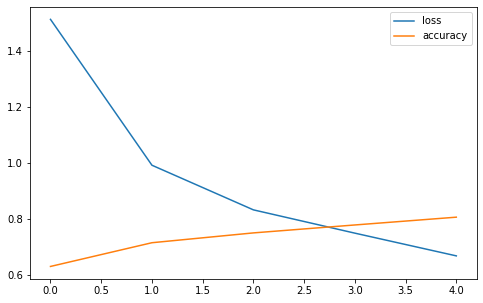

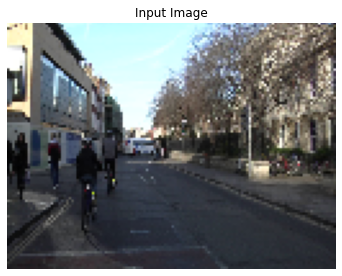

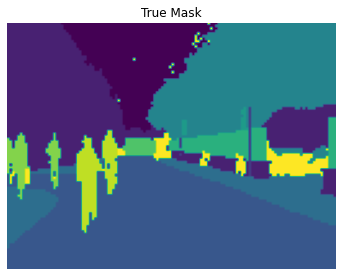

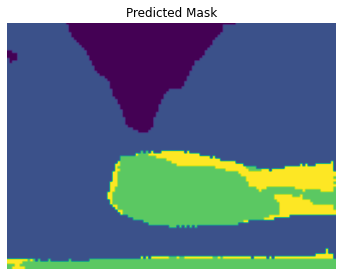

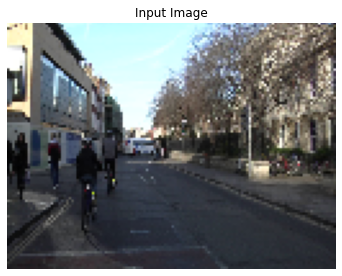

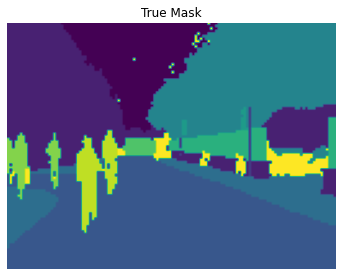

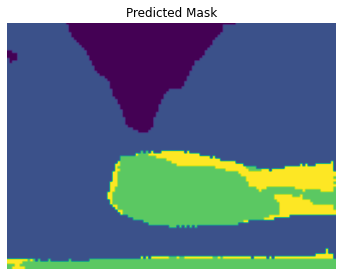

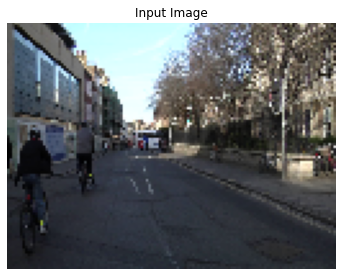

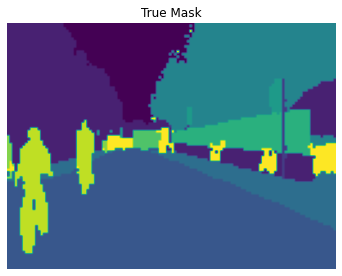

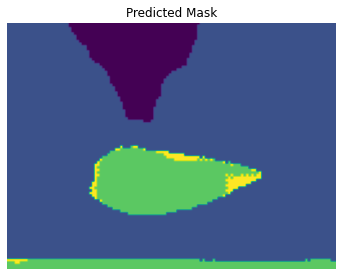

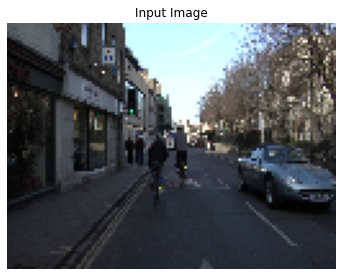

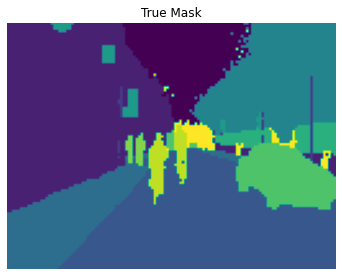

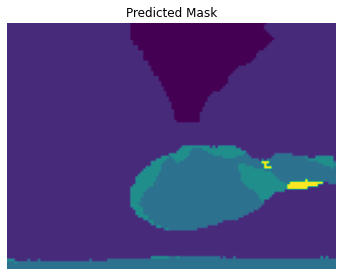

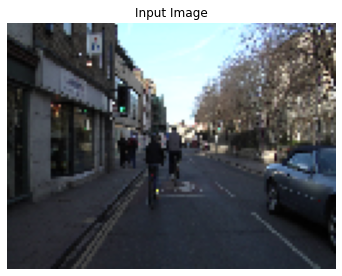

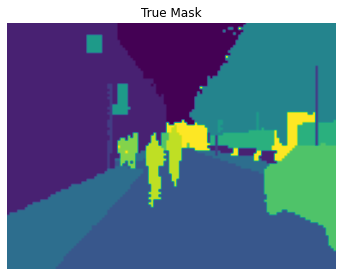

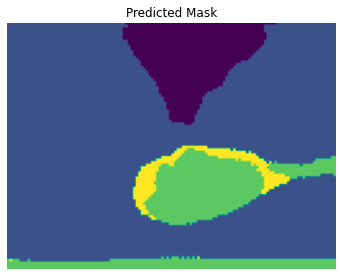

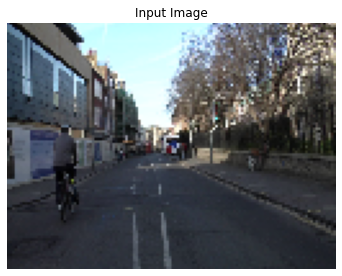

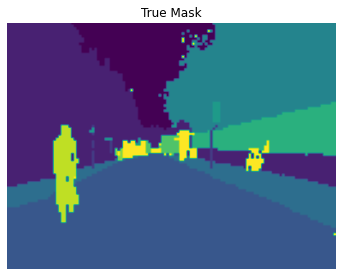

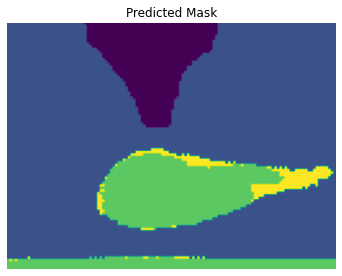

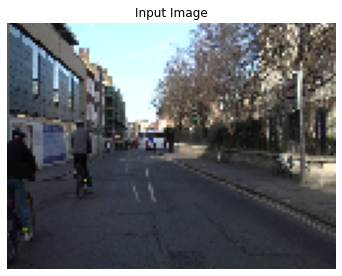

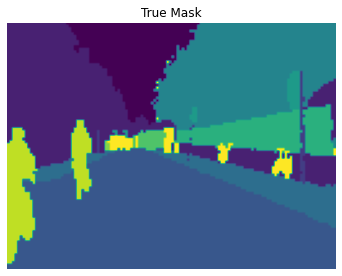

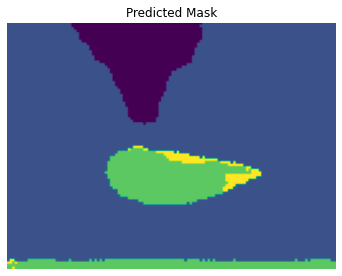

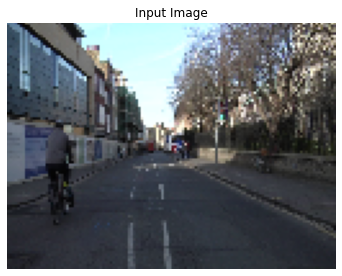

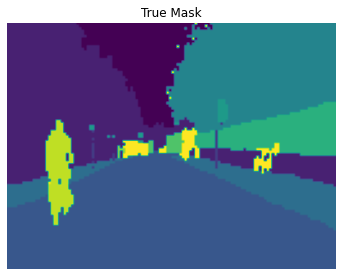

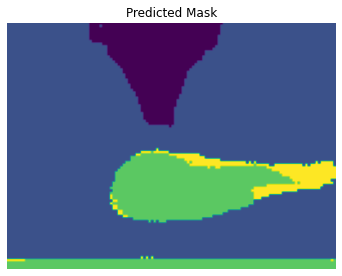

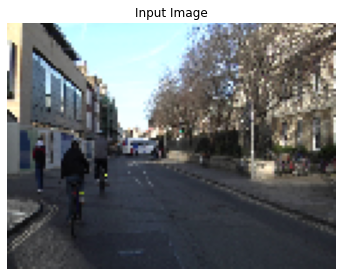

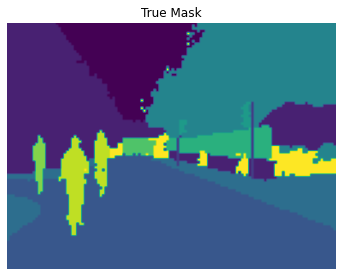

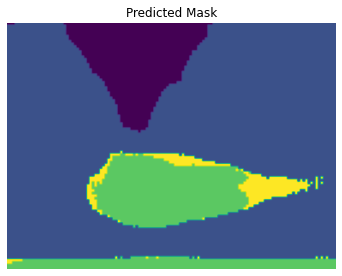

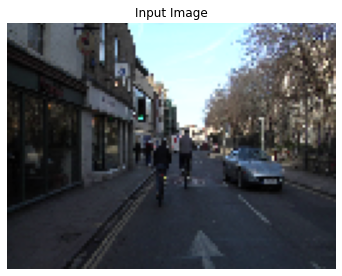

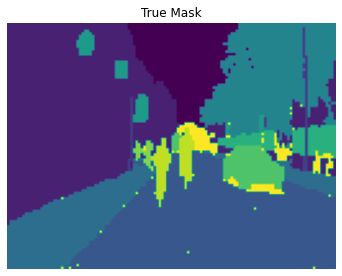

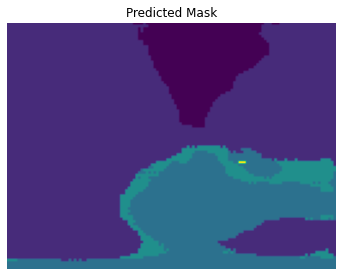

In [ ]:
import pandas as pd
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.show()
for i in range(10):
    index = np.random.randint(Test_Images.shape[0])

    input_image = Test_Images[index]
    true_mask = Test_Masks[index]
    
    pred_mask = unet2(tf.expand_dims(input_image, axis=0))
    pred_mask = create_mask(pred_mask)

    display([input_image, true_mask, pred_mask])

In [ ]:
true_masks,predicted_masks2 = [], []
pred_mask = unet2.predict(Train_Images)
pred_mask2 = tf.expand_dims(tf.argmax(pred_mask,axis=-1), axis = -1)
predicted_masks2.extend(pred_mask2)
predicted_masks2 = np.array(predicted_masks2)



12/12 [==============================] - 54s 4s/step


In [ ]:
evaulations2, metrics = evaluate(Train_Masks, predicted_masks2, 12)
Class_Wise2 = evaulations2['Class-wise Evaluations']
print('Classes:',Class_Wise2['Class'])
print('TP:',Class_Wise2['True Positive Pixels'])
print('TN:',Class_Wise2['True Negative Pixels'])
print('FP:',Class_Wise2['False Positive Pixels'])
print('FN:',Class_Wise2['False Negative Pixels'])
print('Precision:',Class_Wise2['Precision'])
print('Recall:',Class_Wise2['Recall'])
print('IOU:',Class_Wise2['IoU'])
print('F_score:',Class_Wise2['F1-Score'])




Classes: ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12']
TP: [714329, 979187, 0, 738783, 18558, 14981, 0, 0, 3785, 0, 0, 3]
TN: [3544489, 1893984, 4465239, 2957503, 4165340, 4070864, 4457031, 4458894, 4244737, 4480834, 4496576, 4331095]
FP: [205189, 1567112, 0, 124965, 142119, 305, 0, 0, 380, 0, 0, 0]
FN: [45689, 69413, 44457, 688445, 183679, 423546, 52665, 50802, 260794, 28862, 13120, 178598]
Precision: [0.78, 0.38, 0.0, 0.86, 0.12, 0.98, 0.0, 0.0, 0.91, 0.0, 0.0, 1.0]
Recall: [0.94, 0.93, 0.0, 0.52, 0.09, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]
IOU: [0.74, 0.37, 0.0, 0.48, 0.05, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]
F_score: [0.85, 0.54, 0.0, 0.65, 0.1, 0.06, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0]


In [ ]:
unet2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 96, 128, 32)  128        ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
print('Unet IoU values :' ,Class_Wise['IoU'] )
print('Unet2 IoU values :',Class_Wise2['IoU'] )

Unet IoU values : [0.74, 0.37, 0.0, 0.48, 0.05, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]
Unet2 IoU values : [0.74, 0.37, 0.0, 0.48, 0.05, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


In [ ]:
import math
def ensemble(Model_1_IoU_results, Model_2_IoU_results,num_classes):
  ensemble_IoU = []
  for i in range(num_classes):
    sum = Model_1_IoU_results[i] + Model_2_IoU_results[i]
    average = sum/2
    ensemble_IoU.append(average)
  return ensemble_IoU  


In [ ]:
ensemble_IoU = ensemble(Class_Wise['IoU'],Class_Wise2['IoU'],num_classes = 12)


In [ ]:
final = pd.DataFrame([ensemble_IoU],columns = Class_Wise['Class'], index = ['ensemble'] )

In [ ]:
final

Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  \
ensemble     0.74     0.37      0.0     0.48     0.05     0.03      0.0   

          Class 8  Class 9  Class 10  Class 11  Class 12  
ensemble      0.0     0.01       0.0       0.0       0.0